# Module 1 Project: King County House Sales Price Projection


# Part I: Obtain the data and data scrubbing



* Cast columns to the appropriate data types
* Identify and deal with null values appropriately
* Remove unnecessary columns
* Check for and deal with multicollinearity
* Normalize our data


In [38]:
#import libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from collections import Counter

In [39]:
kcdata = pd.read_csv("kc_house_data.csv")

In [3]:
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
kcdata.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## Deal with missing values

In [40]:
#Find missing value: waterfront, view, yr_renovated, and incorrect data type: sqft_basement
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [42]:
#For Categorical data 'Waterfront', replace NAN with 0 since it is highly possible that the house doesn't have a waterfront. 
kcdata['waterfront'].unique()
kcdata['waterfront'] = kcdata['waterfront'].fillna(0)

counter = Counter()
counter = Counter(kcdata['waterfront'])
print(counter)

Counter({0.0: 21451, 1.0: 146})


For view, this variable presents how many times people have viewed the house. Based on common sense, number of times being viewed should not decide the house price. Plus, majority of the values are zero. So we will replace NAN with 0 now and create bins: {0: nobody viewed, 1-2, 3-4}

In [44]:
kcdata['view'].unique()
kcdata['view'] = kcdata['view'].fillna(0)
counter = Counter()
counter = Counter(kcdata['view'])
print(counter)


Counter({0.0: 19485, 2.0: 957, 3.0: 508, 1.0: 330, 4.0: 317})


In [35]:
#There are too many missing values in yr_renovated. And it may not be fair to replace NAN with average. 
#So we will probably not consider this variable into the model.We will fill NaN and remove this column now.
%matplotlib inline
kcdata['yr_renovated'].fillna(0);
kcdata = kcdata.drop('yr_renovated', axis =1);
#kcdata['yr_renovated'].hist()

In [36]:
kcdata.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.233181,3.409825,7.657915,1788.596842,285.716581,1970.999676,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.764673,0.650546,1.173200,827.759761,439.819830,29.375234,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [37]:
kcdata.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
datetime         0
dtype: int64

## Cast columns to the appropriate data types

Change date to datetime, bathrooms to int, waterfront, view, condition, grade as categorical

In [26]:
#Convert strings into dates
from datetime import datetime
kcdata['date'].head()
f = lambda x: datetime.strptime(x,'%m/%d/%Y')
kcdata['datetime']=kcdata['date'].apply(f)
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,datetime
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,2014-10-13
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014-12-09
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,2015-02-25
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,2014-12-09
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2015-02-18


In [11]:
#Convert sqft_basement column from string to numerical
kcdata['sqft_basement'].value_counts()

#Replace ? with zeros for now.
kcdata['sqft_basement'] = kcdata['sqft_basement'].replace('?','0')


kcdata['sqft_basement'] = kcdata['sqft_basement'].astype(dtype=np.float64)
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(9), int64(11), object(1)
memory usage: 3.5+ MB


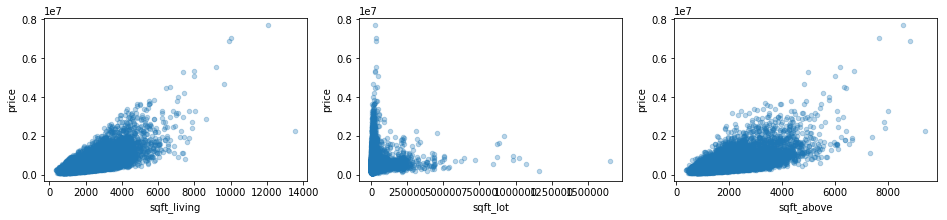

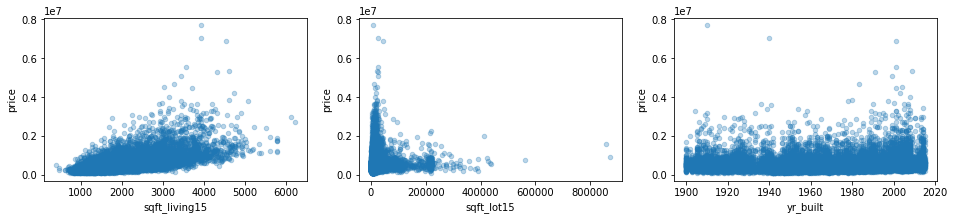

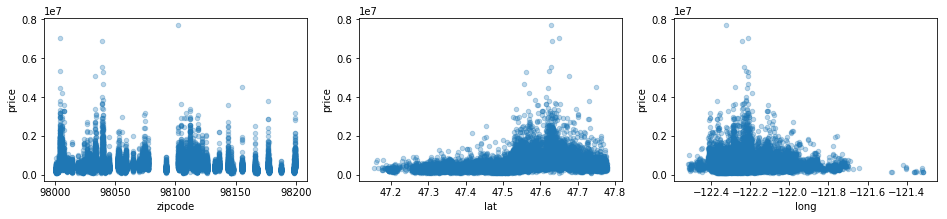

In [14]:
#Plotting potential continuous variables

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list = ['sqft_living','sqft_lot','sqft_above']

for xcol, ax in zip(con_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list2 =['sqft_living15','sqft_lot15','yr_built']

for xcol, ax in zip(con_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)
    
#Plotting zipcode

fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(16,3))
geo_list = ['zipcode','lat','long']

for xcol, ax in zip(geo_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)


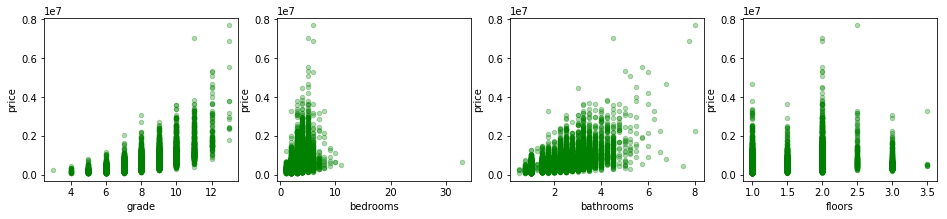

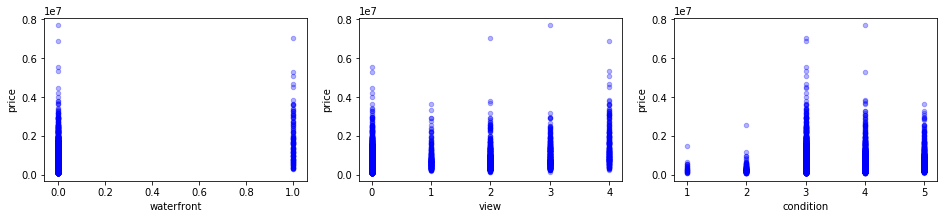

In [15]:
#Plotting other variables. Waterfront is clearly categorical values with binominal values. 
#While view, condition, grade, bedrooms, bathrooms, and floors present actual numerical values so we can keep them numerical. 

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
cat_list1 = ['grade','bedrooms', 'bathrooms','floors']


for xcol, ax in zip(cat_list1, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='g')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))    
cat_list2=['waterfront', 'view', 'condition']
for xcol, ax in zip(cat_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='b')

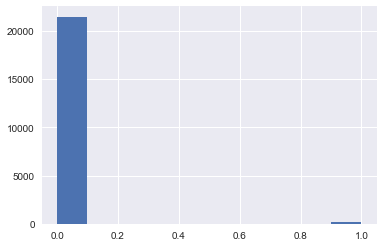

In [33]:
#Convert Waterfront to binominal 
kcdata['waterfront'] = kcdata['waterfront'].astype('category')
kcdata['waterfront'].cat.codes
kcdata['waterfront'].hist(title='Distrivu')
plt.show()


## Deal with Outliers

We can spot outliers for almost all categorical variables. Z-score can be used to detect outliers because by intuition z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points. We can use a threshold of 3 or -3 to decide outliers. i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

In [17]:
kcdep = kcdata.iloc[:,3:]

In [18]:
#Detect outliers

from scipy import stats
import numpy as np
z = np.abs(stats.zscore(kcdep))
print(z)



[[0.40290302 1.45107268 0.98065209 ... 0.30569514 0.94367562 0.26062671]
 [0.40290302 0.17448579 0.53336915 ... 0.74628553 0.43288674 0.18769961]
 [1.48249316 1.45107268 1.4272339  ... 0.13514402 1.07029196 0.17219022]
 ...
 [1.48249316 1.77618438 1.15492792 ... 0.6041596  1.41068259 0.39419807]
 [0.40290302 0.49959749 0.52317805 ... 1.03028865 0.84151784 0.42059702]
 [1.48249316 1.77618438 1.15492792 ... 0.6041596  1.41068259 0.41803046]]


## Part II: Exploratory Data Analysis

From the data dictionary below we can probably tell some are continuous variables (footage of the home/lot/basement/yr_built) and some might be numerical but more like categorical (number of bathrooms/bedrooms, waterfront, view, condition, grade), and other variables we are not sure (zipcode,lat,long). We will visualize them next.

* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


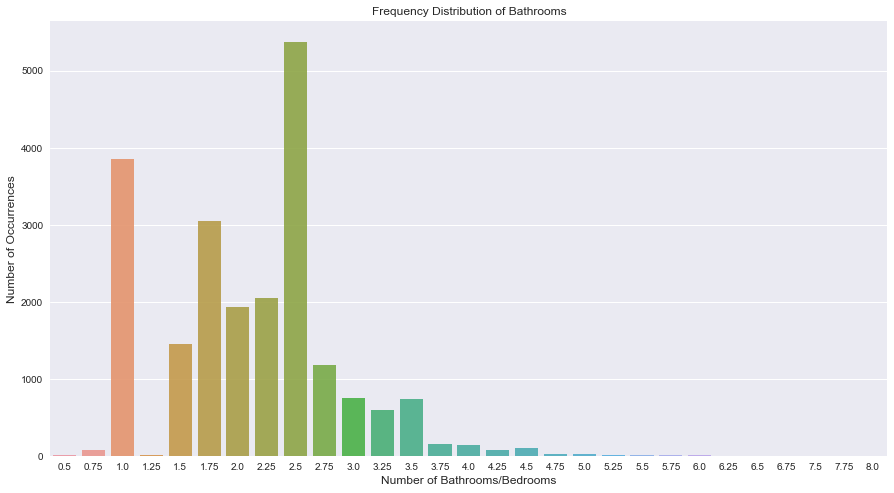

In [16]:
#Value Counts 
#bathroomsNumber - of bathrooms/bedrooms

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
bathroom_count = kcdata['bathrooms'].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
sns.barplot(bathroom_count.index, bathroom_count.values, alpha=0.9)

plt.title('Frequency Distribution of Bathrooms')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Bathrooms/Bedrooms', fontsize=12)
plt.show()

In [47]:
#Visualize Geolocation data
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

ModuleNotFoundError: No module named 'geopandas'